In [1]:
import torch
from torch import nn
from torch.optim import Adam
from model import load_models, Encoder, AttentionDecoder, EMBEDDING_SIZE
import random
from prepared import load_voc, batch2train_data
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data, Vocabulary = load_voc()

In [3]:
device = "cuda:0"
batch_size = 2

In [4]:
Vocabulary.num_words

35691

In [5]:
embedding = nn.Embedding(2**16, EMBEDDING_SIZE).to(device)
encoder = Encoder(embedding).to(device)
decoder = AttentionDecoder(embedding).to(device)

In [6]:
# encoder, decoder, embedding = load_models()

encoder_optim = Adam(encoder.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=5e-4)

encoder.epochs

0

In [7]:
def calculate_loss(inp, target, mask):

    loss = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = loss.masked_select(mask).mean()
    loss = loss.to(device)

    return loss

In [8]:
def train(epochs):
    # для вывода графика
    history = []
    short_mem = []

    for _ in range(epochs):
        # всё стандартно
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        inp, lenghts, target, mask, max_target_len = batch2train_data([random.choice(data) \
                                                                       for _ in range(batch_size)])

        inp = inp.to(device)
        lenghts = lenghts.to(device)
        target = target.to(device)
        mask = mask.to(device)
        # провожу через енкодинг
        encoder_out, encoder_hidden = encoder(inp, lenghts)
        # начальное значение для работы декодера
        decoder_input = torch.ones(batch_size).long().to(device).unsqueeze(0)

        loss = 0

        for i in range(max_target_len):
            decoder_out, decoder_hidden = decoder(decoder_input, encoder_hidden[:2], encoder_out)

            decoder_input = torch.LongTensor([[decoder_out.topk(1)[1][x][0] for\
                                               x in range(batch_size)]]).to(device)

            loss += calculate_loss(decoder_out, target[i], mask[i])

        short_mem.append(loss)

        if not encoder.epochs % 250:
            print(f'{encoder.epochs}  {loss}')
            history.append(torch.tensor(short_mem).mean())
            short_mem = []

        loss.backward()

        encoder_optim.step()
        decoder_optim.step()

        encoder.epochs += 1

        # save model

        if not encoder.epochs % 1000:

            torch.save(encoder, f"models/encoder{encoder.epochs}")
            torch.save(decoder, f"models/decoder{encoder.epochs}")
            torch.save(embedding, f"models/embedding{encoder.epochs}")

    return history

In [9]:
%%time
history = train(10000)

0  387.00775146484375
250  396.31781005859375
500  1299.4212646484375
750  210.7831268310547
1000  360.5287780761719
1250  173.14456176757812
1500  247.78475952148438
1750  572.3201904296875
2000  52.79213333129883
2250  36.03361129760742
2500  15.699657440185547
2750  504.3924865722656
3000  250.3270721435547
3250  224.95924377441406
3500  145.0924530029297
3750  258.6114196777344
4000  61.06736755371094
4250  359.87628173828125
4500  277.4766540527344
4750  24.60407257080078
5000  58.48957443237305
5250  177.70460510253906
5500  128.12498474121094
5750  111.02143859863281
6000  37.861854553222656
6250  24.299524307250977
6500  63.353546142578125
6750  97.99394226074219
7000  24.696056365966797
7250  1164.6624755859375
7500  353.9559020996094
7750  839.18896484375
8000  466.68670654296875
8250  47.057533264160156
8500  745.7867431640625
8750  158.3424072265625
9000  16.43218994140625
9250  560.142822265625
9500  50.350894927978516
9750  86.2644271850586
CPU times: user 26min 23s, sys:

In [10]:
encoder.epochs

10000

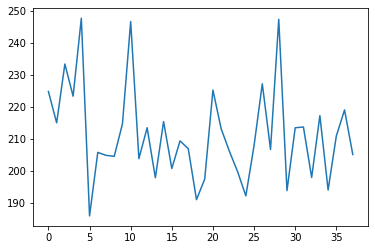

In [12]:
plt.plot(history[2:])
